In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alibaba-stock-dataset-2025/Ali_Baba_Stock_Data.csv


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV

In [14]:
df=pd.read_csv('/kaggle/input/alibaba-stock-dataset-2025/Ali_Baba_Stock_Data.csv')
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400
1,2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800
2,2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800
3,2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000
4,2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Close,2617.0,1.307630e+02,5.674174e+01,5.542420e+01,8.244579e+01,1.054692e+02,1.730618e+02,3.062769e+02
Close,2617.0,1.351539e+02,5.895156e+01,5.739000e+01,8.485000e+01,1.089900e+02,1.792000e+02,3.171400e+02
High,2617.0,1.369197e+02,5.957959e+01,5.865000e+01,8.570000e+01,1.106500e+02,1.813900e+02,3.193200e+02
Low,2617.0,1.333609e+02,5.824422e+01,5.720000e+01,8.400000e+01,1.072600e+02,1.770000e+02,3.089100e+02
Open,2617.0,1.352487e+02,5.903747e+01,5.730000e+01,8.500000e+01,1.085000e+02,1.793700e+02,3.135000e+02
Volume,2617.0,1.899231e+07,1.291504e+07,3.775300e+06,1.186070e+07,1.600840e+07,2.172430e+07,2.718794e+08


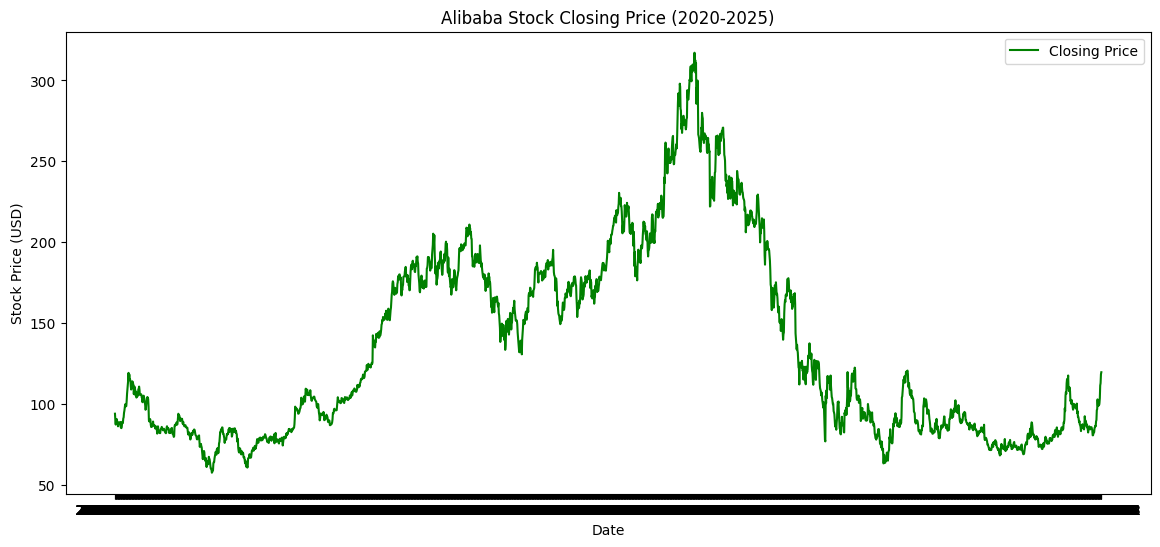

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='green')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Alibaba Stock Closing Price (2020-2025)")
plt.legend()
plt.show()

In [17]:
df['30_MA'] = df['Close'].rolling(window=30).mean()
df['365_MA'] = df['Close'].rolling(window=365).mean()
df['1825_MA'] = df['Close'].rolling(window=1825).mean() ## 5 years

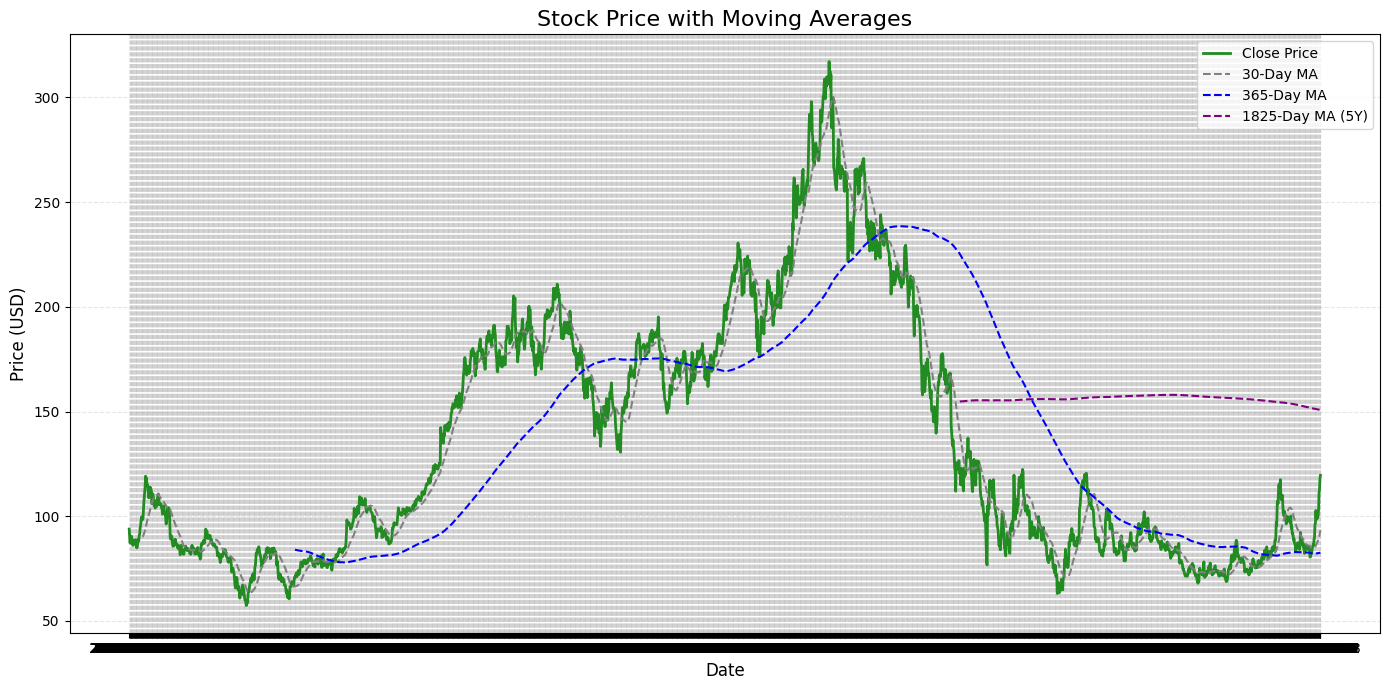

In [18]:
plt.figure(figsize=(14, 7))
normal_green = "#228B22"  # ForestGreen
plt.plot(df['Date'], df['Close'], label='Close Price', color=normal_green, linewidth=2)
plt.plot(df['Date'], df['30_MA'], label='30-Day MA', color='gray', linestyle='dashed', linewidth=1.5)
plt.plot(df['Date'], df['365_MA'], label='365-Day MA', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(df['Date'], df['1825_MA'], label='1825-Day MA (5Y)', color='purple', linestyle='dashed', linewidth=1.5)
plt.title('Stock Price with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.style.use('default')
plt.tight_layout()
plt.show()


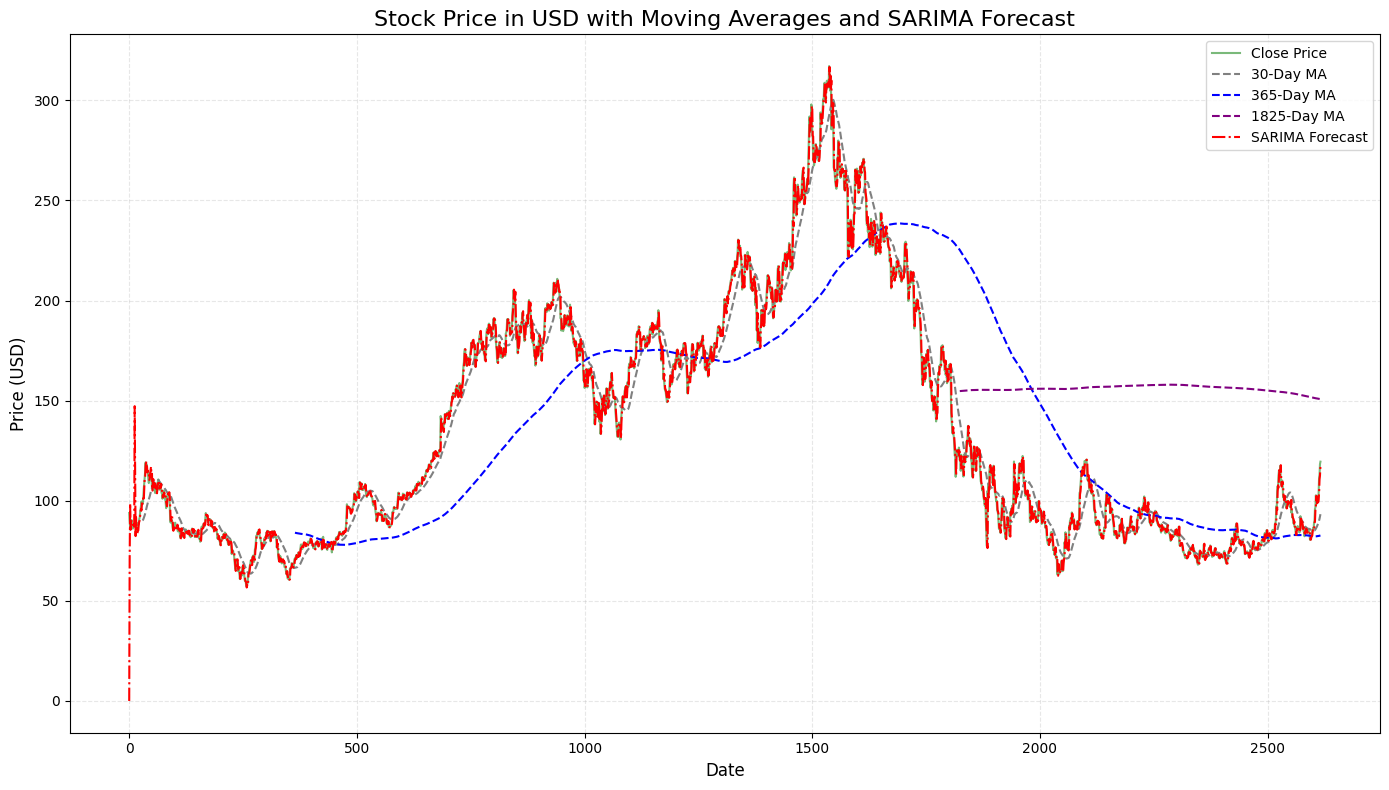

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(df['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)
df['SARIMA_Forecast'] = sarima_result.predict(start=0, end=len(df)-1)
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='forestgreen', alpha=0.6)
plt.plot(df.index, df['30_MA'], label='30-Day MA', color='gray', linestyle='--')
plt.plot(df.index, df['365_MA'], label='365-Day MA', color='blue', linestyle='--')
plt.plot(df.index, df['1825_MA'], label='1825-Day MA', color='purple', linestyle='--')
plt.plot(df.index, df['SARIMA_Forecast'], label='SARIMA Forecast', color='red', linestyle='-.')

plt.title('Stock Price in USD with Moving Averages and SARIMA Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
y=df['Adj Close']
x=df.drop(['Adj Close','Date'],axis=1)

In [21]:
x.fillna(df.median,inplace=True)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/tmp/ipykernel_36/3832354047.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<bound method DataFrame.median of             Date   Adj Close       Close        High         Low        Open  \
0     2014-09-19   90.673950   93.889999   99.699997   89.949997   92.699997   
1     2014-09-22   86.810966   89.889999   92.949997   89.50

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True,random_state=42)
x_train_cleaned = x_train.drop(columns=["30_MA", "365_MA", "1825_MA"])
x_test_cleaned = x_test.drop(columns=["30_MA", "365_MA", "1825_MA"])


In [23]:
xgb_params = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3],
    "subsample": [0.6, 0.7],
    "colsample_bytree": [0.6, 0.7, 0.8],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0.5, 1, 1.5]
}

model=XGBRegressor()
randomizedxgbmodel=RandomizedSearchCV(estimator=model,param_distributions=xgb_params,cv=5, scoring='neg_root_mean_squared_error',
verbose=1,
random_state=42,
n_jobs=-1)
randomizedxgbmodel.fit(x_train_cleaned,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3],
                                        'n_estimators': [100, 300, 500],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0.5, 1, 1.5],
                                        'subsample': [0.6, 0.7]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [24]:
bestrandom_model=randomizedxgbmodel.best_estimator_
bestrandom_model.fit(x_train_cleaned,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 5, 8],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}
randomized_rf_model = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=25,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

randomized_rf_model.fit(x_train_cleaned, y_train)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 8],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 300]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [27]:
bestrf=randomized_rf_model.best_estimator_
bestrf.fit(x_train_cleaned,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=300, random_state=42)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
base_learners = [
    ('rf1', bestrf),
    ('xgb', bestrandom_model)
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model,
    passthrough=True,  
    cv=5,              
    n_jobs=-1          
)
stacking_model.fit(x_train_cleaned,y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

StackingRegressor(cv=5,
                  estimators=[('rf1',
                               RandomForestRegressor(max_depth=8,
                                                     max_features='auto',
                                                     min_samples_leaf=3,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_cate...
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression(), n_jobs=-1,
                  passthrough=True)

In [37]:
y_pred=stacking_model.predict(x_test_cleaned)
rmse=np.sqrt(mean_squared_error(y_pred,y_test))
print(rmse)

0.7518564485065455


In [38]:
r2_score(y_pred,y_test)

0.9998198597332579

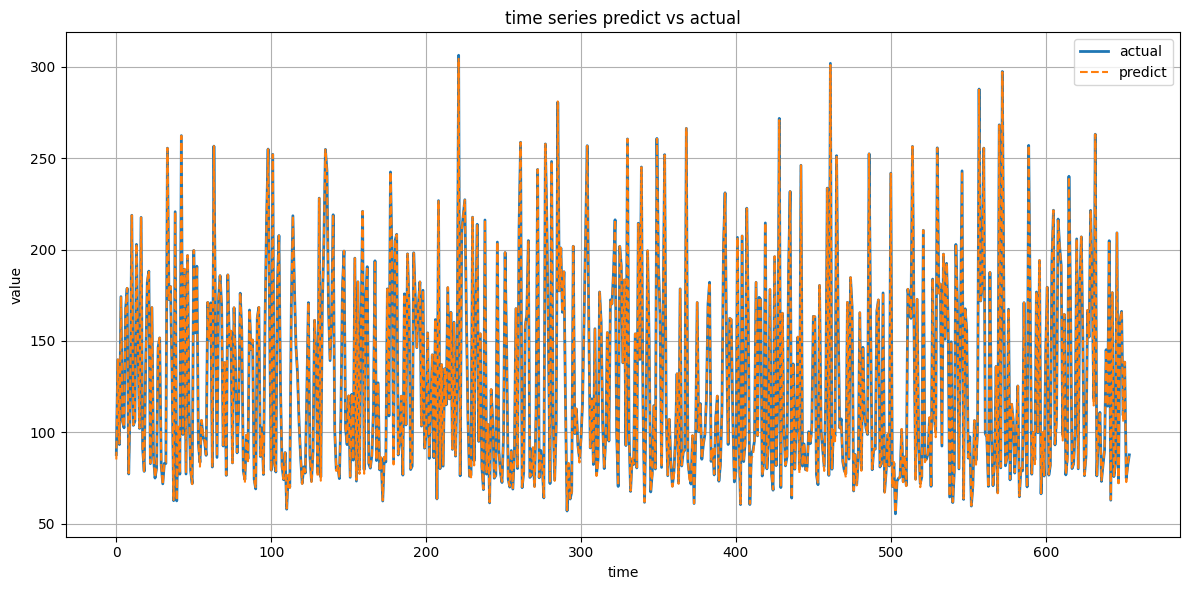

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='actual', linewidth=2)
plt.plot(y_pred, label='predict', linestyle='--')
plt.title('time series predict vs actual')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()